## **Algorithme de Prédiction de race de chiens Deep Learning** 

# Introduction
Ce projet de cours, consiste a mettre en place un réseau de neurones convolutionelle capable de prédire la race d'un chien. 

Dans le cadre de ce projet nous avons utilisé la banque d'images disponible à l'adresse suivante :

http://vision.stanford.edu/aditya86/ImageNetDogs/

En ce qui concerne notre dataset, nous avons fait le choix de commencer par prendre 12 catégories de race de chiens (10%) pour des soucis de GPU. 
Puis nous généraliserons nos résultats.
- Chihuahua
- Japanese_spaniel
- Maltese_dog
- Pekinese
- Shih-Tzu
- Blenheim_spaniel
- Papillon
- Toy_terrier
- Rhodesian_ridgeback
- Afghan_hound
- Basset
- Beagle

Dans un premier temps nous allons effectuer un travail de pré-traitement (Pre-processing), qui consiste à remettre en forme notre jeu de données (redimensionner, cropping, débruitage...).
Puis nous allons créer notre réseau de neuronnes convolutif CNN. Ensuite nous mettrons en place le Transfer Learning, pour enfin terminer sur une phase de conclusion.

Tout d'abord il est nécessaire d'importer et de dézipper le jeu de données appelé Data.zip


In [ ]:
!unzip Data.zip -d /content/Projet/

# Pre-processing

## Renommage des images
Dans un premier temps nous allons renommer chacunes des images avec pour nom leur type de race.

Exemple : CHIHUAHUA(1).jpg / AFGHAN_HOUND(3).jpg

## Redimensionnement des images

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from IPython import display
import glob
import pandas as pd
import numpy as np
import os
import tensorflow as tf 
import matplotlib.pyplot as plt
import pathlib 

In [ ]:
# Init des chemins
path_Train = "/content/Projet/TRAIN/"
path_Test = "/content/Projet/TEST/"
IMG_SIZE = [224,224]
NB_CLASSIFICATION = 12
# Enregistrement des chemins des images 
train_set = pathlib.Path(path_Train)
test_set = pathlib.Path(path_Test)

all_image_paths_Train = [str(img_path) for img_path in list(train_set.glob("*.jpg"))]
all_image_paths_Test = [str(img_path) for img_path in list(test_set.glob("*.jpg"))]
all_image_paths_Train[:5]

['/content/Projet/TRAIN/RHODESIAN_RIDGEBACK (111).jpg',
 '/content/Projet/TRAIN/AFGHAN_HOUND (109).jpg',
 '/content/Projet/TRAIN/PAPILLON (49).jpg',
 '/content/Projet/TRAIN/JAPANESE_SPANIEL (6).jpg',
 '/content/Projet/TRAIN/BEAGLE (179).jpg']

In [ ]:
# Lecture et decode des images
all_image_bytes = [tf.io.read_file(path) for path in all_image_paths_Train]
all_image_tensors = [tf.image.decode_jpeg(img_byte) for img_byte in all_image_bytes]

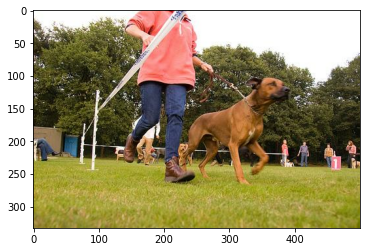

In [ ]:
# Exemple d'image avant redimensionnement
plt.imshow(all_image_tensors[0])

In [ ]:
# Création du Dataset d'entrainement
tf_train_set = tf.data.Dataset.from_tensor_slices(all_image_paths_Train)
tf_train_set

<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
# Création du Dataset de Test
tf_test_set = tf.data.Dataset.from_tensor_slices(all_image_paths_Test)
tf_test_set

<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
# Fonction de traitement et de mise en forme des images
def load_and_preprocess_images(img):
  img = tf.io.read_file(img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
  img = img / 255.0

  return img

In [ ]:
# Application de la fonction de preprocessing
tf_train_set = tf_train_set.map(load_and_preprocess_images)
tf_test_set = tf_test_set.map(load_and_preprocess_images)
tf_train_set

<MapDataset shapes: (224, 224, 3), types: tf.float32>

In [ ]:
# Récupération des différentes classification disponible (en fonction des noms des images)
labels = []
for a in train_set.iterdir():
    classif = a.name.split(' ', 1)[0]    
    if (classif not in labels):
        labels.append(classif)
  
labels

['RHODESIAN_RIDGEBACK',
 'AFGHAN_HOUND',
 'PAPILLON',
 'JAPANESE_SPANIEL',
 'BEAGLE',
 'CHIHUAHUA',
 'TOY_TERRIER',
 'BLENHEIM_SPANIEL',
 'PEKINESE',
 'SHIH_TZU',
 'BASSET',
 'MALTESE']

Au lieu de la classification au format string nous aurons besoin d'un entier, nous allons donc créer un dictionnaire ayant pour clé le nom de la classification et pour valeur un numéro d'index.

In [ ]:
# Création d'un dictionnaire d'index avec les classifications associées
label_index = {}
for i, label in enumerate(labels):
  label_index[label]= i
  
label_index  

{'AFGHAN_HOUND': 1,
 'BASSET': 10,
 'BEAGLE': 4,
 'BLENHEIM_SPANIEL': 7,
 'CHIHUAHUA': 5,
 'JAPANESE_SPANIEL': 3,
 'MALTESE': 11,
 'PAPILLON': 2,
 'PEKINESE': 8,
 'RHODESIAN_RIDGEBACK': 0,
 'SHIH_TZU': 9,
 'TOY_TERRIER': 6}

Nous allons donc maintenant créer une liste du même type mais cette fois de la longueur des éléments composant notre jeu d'entrainement.

In [ ]:
# Création d'une liste contenant l'index correspondant à la race du chien associé 
all_image_labels_Train = [label_index[path.name.split(' ', 1)[0]] for path in list(train_set.glob("*.jpg"))]
all_image_labels_Test = [label_index[path.name.split(' ', 1)[0]] for path in list(test_set.glob("*.jpg"))]

In [ ]:
# Nombre d'images d'entrainement
print("Nb d'images dans le jeu d'entrainement :",len(all_image_labels_Train))
print("Nb d'images dans le jeu de Test :",len(all_image_labels_Test))

Nb d'images dans le jeu d'entrainement : 2229
Nb d'images dans le jeu de Test : 60


In [ ]:
from tensorflow.keras.utils import to_categorical
# Conversion de l'index en matrice de 0/1 avec pour taille le nombre de classes
all_image_labels_Train_one_hot = to_categorical(all_image_labels_Train) 
all_image_labels_Test_one_hot = to_categorical(all_image_labels_Test) 

In [ ]:
all_image_labels_Train_one_hot[6]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Association de la liste au Dataset
tf_labels_Train = tf.data.Dataset.from_tensor_slices(all_image_labels_Train_one_hot)
tf_labels_Test = tf.data.Dataset.from_tensor_slices(all_image_labels_Test_one_hot)

for example in tf_labels_Train.take(2):
  print(example)

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(12,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(12,), dtype=float32)


Maintenant que nous avons d'un côté le dataset contenant les images après traitement, et d'un autre les différentes classifications, nous allons fusionner ces derniers afin de constituer un dataset complet.

In [ ]:
# Constitution du Dataset complet
full_ds_Train = tf.data.Dataset.zip((tf_train_set, tf_labels_Train))
full_ds_Test = tf.data.Dataset.zip((tf_test_set, tf_labels_Test))

for example in full_ds_Train.take(1):
  print(example)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[9.8431373e-01, 1.0000000e+00, 1.0000000e+00],
        [9.8431373e-01, 1.0000000e+00, 9.9334735e-01],
        [9.8462886e-01, 1.0000000e+00, 9.8399860e-01],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],

       [[9.8431373e-01, 1.0000000e+00, 1.0000000e+00],
        [9.8717612e-01, 1.0000000e+00, 9.9334735e-01],
        [9.8726124e-01, 1.0000000e+00, 9.8399860e-01],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],

       [[9.8993343e-01, 1.0000000e+00, 1.0000000e+00],
        [9.8993343e-01, 1.0000000e+00, 1.0000000e+00],
        [9.8993343e-01, 1.0000000e+00, 9.8431373e-01],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+0

In [ ]:
# Mélange du dataset + création de batchs
full_ds_Train = full_ds_Train.shuffle(len(all_image_paths_Train)).batch(64)
full_ds_Test = full_ds_Test.shuffle(len(all_image_paths_Test)).batch(16)

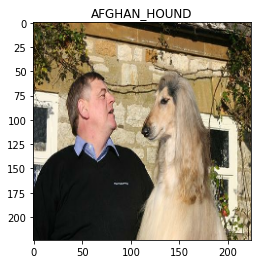

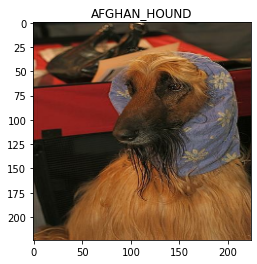

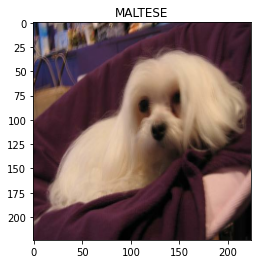

In [ ]:
# Affichage d'exemple d'enregistrement du Dataset complet d'entrainement
# ! Images bien redimensionnées 224*224 !
for example_x, example_y in full_ds_Train.take(3):
  plt.figure()
  plt.title(list(label_index.keys())[list(label_index.values()).index(np.argmax(example_y[0].numpy()))])
  plt.imshow(example_x[0].numpy())
  
plt.show()

# Création d'un CNN

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras

# Création d'un model 
def model_CNN():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=[IMG_SIZE[0], IMG_SIZE[1],3]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())    
    model.add(Dense(256))
    model.add(Dense(NB_CLASSIFICATION, activation='softmax'))
    return model

model = model_CNN()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 110, 110, 64)      51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 55, 55, 64)        102464    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 46656)            

In [ ]:
# Création d'un schedule learning rate 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

In [ ]:
# Création d'un compileur
model.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

In [ ]:
model.fit(full_ds_Train, epochs=20)

Epoch 1/20
35/35 [==============================] - 12s 201ms/step - loss: 0.3668 - binary_accuracy: 0.9167
Epoch 2/20
35/35 [==============================] - 11s 202ms/step - loss: 0.2814 - binary_accuracy: 0.9167
Epoch 3/20
35/35 [==============================] - 11s 201ms/step - loss: 0.2564 - binary_accuracy: 0.9179
Epoch 4/20
35/35 [==============================] - 11s 202ms/step - loss: 0.2234 - binary_accuracy: 0.9238
Epoch 5/20
35/35 [==============================] - 11s 203ms/step - loss: 0.1983 - binary_accuracy: 0.9304
Epoch 6/20
35/35 [==============================] - 11s 202ms/step - loss: 0.1698 - binary_accuracy: 0.9436
Epoch 7/20
35/35 [==============================] - 10s 201ms/step - loss: 0.1436 - binary_accuracy: 0.9545
Epoch 8/20
35/35 [==============================] - 11s 202ms/step - loss: 0.1163 - binary_accuracy: 0.9698
Epoch 9/20
35/35 [==============================] - 11s 203ms/step - loss: 0.0875 - binary_accuracy: 0.9791
Epoch 10/20
35/35 [=========

In [ ]:
# Evaluation du modèle à l'aide du jeu de Test
model.evaluate(full_ds_Test)

4/4 [==============================] - 1s 27ms/step - loss: 0.7093 - binary_accuracy: 0.8806


[0.709272027015686, 0.8805555105209351]

On se rend compte que le score accuracy de notre test est légèrement plus inférieur que notre modèle d'entrainement. Ainsi on se retrouve donc avec un modèle assez précis

# Utilisation du Transfer Learning

Pour le Transfer Learning nous avons utilisé le modèle XCeption

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.applications import xception
from keras.models import Model

In [ ]:
model_xception = xception.Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3))

print(model_xception.summary())

In [ ]:
x = model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
output = Dense(NB_CLASSIFICATION,activation='softmax')(x)

In [ ]:
New_Model_XCEption = Model(model_xception.input,output)

In [ ]:
for layers in New_Model_XCEption.layers:
	layers.trainable=False

In [ ]:
if os.path.exists("weight_mediaeval.h5"):
        print ("loading ", "weight_mediaeval.h5")
        model.load_weights('weight_mediaeval.h5')

checkpoint = tf.keras.callbacks.ModelCheckpoint('weight_mediaeval.h5',verbose=1);

In [ ]:
New_Model_XCEption.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
                  loss= tf.keras.losses.binary_crossentropy,
                  metrics = [tf.keras.metrics.binary_accuracy])
New_Model_XCEption.summary()

In [ ]:
New_Model_XCEption.fit(full_ds_Test, epochs=20)

Epoch 1/20
4/4 [==============================] - 9s 161ms/step - loss: 0.6813 - binary_accuracy: 0.9167
Epoch 2/20
4/4 [==============================] - 1s 154ms/step - loss: 0.6777 - binary_accuracy: 0.9167
Epoch 3/20
4/4 [==============================] - 1s 154ms/step - loss: 0.6792 - binary_accuracy: 0.9167
Epoch 4/20
4/4 [==============================] - 1s 153ms/step - loss: 0.6777 - binary_accuracy: 0.9167
Epoch 5/20
4/4 [==============================] - 1s 154ms/step - loss: 0.6775 - binary_accuracy: 0.9167
Epoch 6/20
4/4 [==============================] - 1s 154ms/step - loss: 0.6774 - binary_accuracy: 0.9167
Epoch 7/20
4/4 [==============================] - 1s 153ms/step - loss: 0.6799 - binary_accuracy: 0.9167
Epoch 8/20
4/4 [==============================] - 1s 153ms/step - loss: 0.6753 - binary_accuracy: 0.9167
Epoch 9/20
4/4 [==============================] - 1s 156ms/step - loss: 0.6770 - binary_accuracy: 0.9167
Epoch 10/20
4/4 [==============================] - 1s 1

In [ ]:
New_Model_XCEption.evaluate(full_ds_Test)

4/4 [==============================] - 1s 163ms/step - loss: 0.6792 - binary_accuracy: 0.9167


[0.6792173385620117, 0.9166666865348816]

Après utilisation du Transfer Learning on se rend compte que ce dernier est tout de même plus précis que notre modèle pré-entrainé. En effet on se retrouve avec une accuracy de 91.67 % avec un loss de 67.92 %, contre 88.06 % d'accuracy et 70.93 % de loss en ce qui concerne notre CNN. 

Cela peut s'améliorer en ajoutant davantages de couches de convolution à notre modèle mais aussi en affinant le paramétrage de ce dernier.


Il est aussi possible de faire de la data augmentation, pour cela il suffirait de générer de la "fausse data", en partant des images utilisées pour l'entrainement, il faudrait simplement recréer des images en effectuant certaines rotations ou des changements d'axe. Pour enfin les repasser dans le modèle.
